In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib
import json
from time import sleep

In [2]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    dataMat = []                #assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float,curLine)) #map all elements to float()
        dataMat.append(fltLine)
    return np.mat(dataMat)

In [3]:
xMat = loadDataSet("testSet.txt")

In [4]:
def plotMat(x):
    plt.scatter(x[:,0].A, x[:,1].A, marker='x', color = 'r')
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.show()

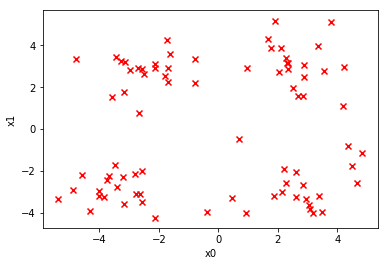

In [5]:
plotMat(xMat)

In [6]:
# 计算两个点的欧氏距离
def distEclud(vecA, vecB):
    #return np.sqrt(sum(np.power(vecA - vecB, 2).A.ravel())) #la.norm(vecA-vecB)
    return np.sqrt(np.sum(np.power(vecA - vecB, 2))) #la.norm(vecA-vecB)

In [7]:
def randCent(dataSet, k):
    n = np.shape(dataSet)[1]
    centroids = np.mat(np.zeros((k,n)))#create centroid mat
    for j in range(n):#create random cluster centers, within bounds of each dimension
        minJ = min(dataSet[:,j]) 
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = np.mat(minJ + rangeJ * np.random.rand(k,1))
    return centroids

In [8]:
randCent(xMat,5)

matrix([[ 3.42588476,  3.78332835],
        [-5.3316686 ,  1.05632301],
        [-0.18559113,  2.94377153],
        [-4.37119377,  1.32304226],
        [-1.09805742,  2.43210017]])

In [9]:
def innerkMeans(dataSet,centroids, k, distMeas=distEclud, createCent=randCent):
    m = np.shape(dataSet)[0]
    clusterAssment = np.mat(np.zeros((m,2)))#create mat to assign data points 
                                      #to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):#for each data point assign it to the closest centroid
            minDist = np.inf; minIndex = -1
            for j in range(k):
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                #print(centroids[j,:],dataSet[i,:],distJI)
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
        # print(centroids)
        # 重新计算 质心
        for cent in range(k):#recalculate centroids
            ptsInClust = dataSet[np.nonzero(clusterAssment[:,0].A==cent)[0]]#get all the point in this cluster
            if len(ptsInClust)>0:
                centroids[cent,:] = np.mean(ptsInClust, axis=0) #assign centroid to mean 
    return centroids, clusterAssment

In [10]:
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    centroids = createCent(dataSet, k)
    return innerkMeans(dataSet,centroids, k, distMeas, createCent)

In [11]:
def plotMat2(x, k, c, idx, m):
    for i in range(k):
        idx0 = np.where(idx[:,0] == i)
        plt.scatter(x[idx0,0].A, x[idx0,1].A, marker = '.', color = m[i])
    plt.scatter(c[:,0].A,c[:,1].A, s=60 , marker = '^', color = m)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.show()

In [12]:
centroids, clusterAssment = kMeans(xMat,6)

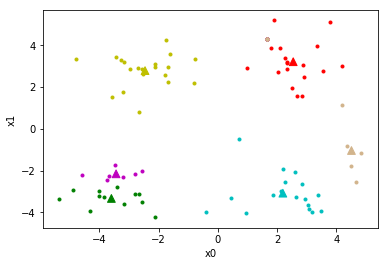

In [13]:
plotMat2(xMat, 8, centroids, clusterAssment, ['r','g','c','y','m','tan','gold','navy','pink'] )

In [14]:
def biKmeans(dataSet, k, distMeas=distEclud):
    m = np.shape(dataSet)[0]
    clusterAssment = np.mat(np.zeros((m,2)))
    centroid0 = np.mean(dataSet, axis=0).tolist()[0]
    centList =[centroid0] #create a list with one centroid
    for j in range(m):#calc initial Error
        clusterAssment[j,1] = distMeas(np.mat(centroid0), dataSet[j,:])**2
    while (len(centList) < k):
        lowestSSE = np.inf
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[np.nonzero(clusterAssment[:,0].A==i)[0],:]
            #get the data points currently in cluster i
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = np.sum(splitClustAss[:,1])#compare the SSE to the currrent minimum
            sseNotSplit = np.sum(clusterAssment[np.nonzero(clusterAssment[:,0].A!=i)[0],1])
            # print("sseSplit, and notSplit: ",sseSplit,sseNotSplit)
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        bestClustAss[np.nonzero(bestClustAss[:,0].A == 1)[0],0] = len(centList)
        #change 1 to 3,4, or whatever
        bestClustAss[np.nonzero(bestClustAss[:,0].A == 0)[0],0] = bestCentToSplit
        print ('the bestCentToSplit is: ',bestCentToSplit)
        print ('the len of bestClustAss is: ', len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0]
        #replace a centroid with two best centroids 
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[np.nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss
        #reassign new clusters, and SSE
    return np.mat(centList), clusterAssment

In [15]:
centroids, clusterAssment = biKmeans(xMat,6)

the bestCentToSplit is:  0
the len of bestClustAss is:  80
the bestCentToSplit is:  1
the len of bestClustAss is:  40
the bestCentToSplit is:  0
the len of bestClustAss is:  40
the bestCentToSplit is:  2
the len of bestClustAss is:  20
the bestCentToSplit is:  1
the len of bestClustAss is:  20


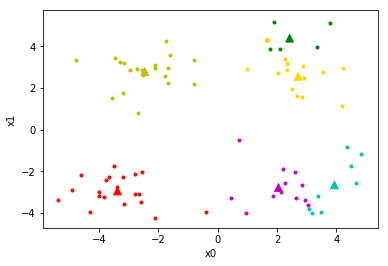

In [16]:
plotMat2(xMat, 6 , centroids, clusterAssment, ['r','g','c','y','m','gold','navy','pink','crimson','orange'] )

In [17]:
centroids, clusterAssment = innerkMeans(xMat,centroids, 6)

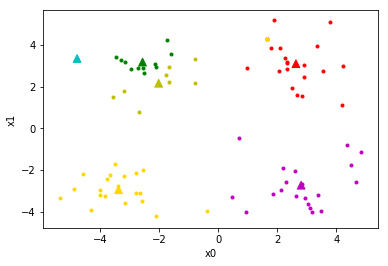

In [18]:
plotMat2(xMat, 6 , centroids, clusterAssment, ['r','g','c','y','m','gold','navy','pink','crimson','orange'] )

In [19]:
centroids, clusterAssment = kMeans(xMat, 6)

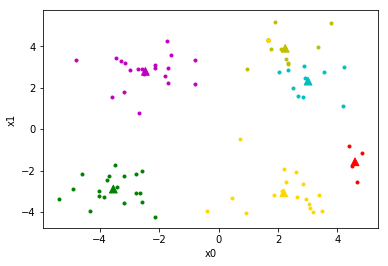

In [20]:
plotMat2(xMat, 6 , centroids, clusterAssment, ['r','g','c','y','m','gold','navy','pink','crimson','orange'] )

In [21]:
xMat2 = loadDataSet('testSet2.txt')

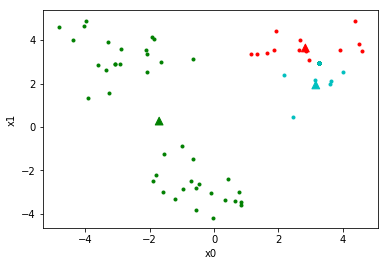

In [22]:
c2, a2 = kMeans(xMat2, 3)
plotMat2(xMat2, 3 , c2, a2, ['r','g','c','y','m','gold','navy','pink','crimson','orange'] )

the bestCentToSplit is:  0
the len of bestClustAss is:  60
the bestCentToSplit is:  1
the len of bestClustAss is:  40
the bestCentToSplit is:  0
the len of bestClustAss is:  20
the bestCentToSplit is:  1
the len of bestClustAss is:  20


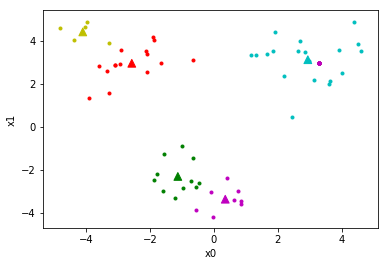

In [23]:
c2, a2 = biKmeans(xMat2, 5)
plotMat2(xMat2, 5 , c2, a2, ['r','g','c','y','m','gold','navy','pink','crimson','orange'] )

# 有一个错误没有解决
右上角有一个 飞点 不知道怎么回事？

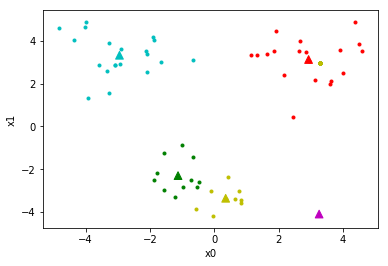

In [24]:
c2, a2 = innerkMeans(xMat2,c2, 5)
plotMat2(xMat2, 5 , c2, a2, ['r','g','c','y','m','gold','navy','pink','crimson','orange'] )

In [25]:
def distSLC(vecA, vecB):#Spherical Law of Cosines
    a = np.sin(vecA[0,1]*np.pi/180) * np.sin(vecB[0,1]*np.pi/180)
    b = np.cos(vecA[0,1]*np.pi/180) * np.cos(vecB[0,1]*np.pi/180) * \
                      np.cos(np.pi * (vecB[0,0]-vecA[0,0]) /180)
    return np.arccos(a + b)*6371.0 #pi is imported with numpy

In [26]:
def clusterClubs(numClust=5, km = kMeans ):
    datList = []
    for line in open('places.txt').readlines():
        lineArr = line.split('\t')
        datList.append([float(lineArr[4]), float(lineArr[3])])
    datMat =np.mat(datList)
    myCentroids, clustAssing = km(datMat, numClust, distMeas=distSLC)
    fig = plt.figure()
    rect=[0.1,0.1,0.8,0.8]
    scatterMarkers=['s', 'o', '^', '8', 'p', \
                    'd', 'v', 'h', '>', '<']
    axprops = dict(xticks=[], yticks=[])
    ax0=fig.add_axes(rect, label='ax0', **axprops)
    imgP = plt.imread('Portland.png')
    ax0.imshow(imgP)
    ax1=fig.add_axes(rect, label='ax1', frameon=False)
    for i in range(numClust):
        ptsInCurrCluster = datMat[np.nonzero(clustAssing[:,0].A==i)[0],:]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:,0].flatten().A[0], \
                    ptsInCurrCluster[:,1].flatten().A[0], marker=markerStyle, s=90)
    ax1.scatter(myCentroids[:,0].flatten().A[0], myCentroids[:,1].flatten().A[0], marker='+', s=300)
    plt.show()

the bestCentToSplit is:  0
the len of bestClustAss is:  69
the bestCentToSplit is:  1
the len of bestClustAss is:  32
the bestCentToSplit is:  1
the len of bestClustAss is:  20
the bestCentToSplit is:  0
the len of bestClustAss is:  37


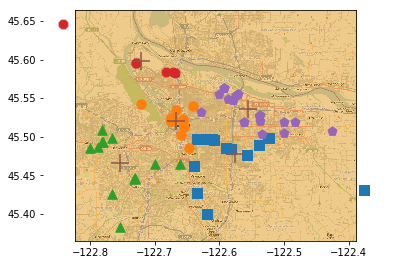

In [27]:
clusterClubs(5, biKmeans)